
<h1><center id="title">DataLab Cup 3: Reverse Image Caption</center></h1>

<center id="author">Shan-Hung Wu &amp; DataLab<br/>Fall 2025</center>



In [19]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path
from tqdm import tqdm

import re
from IPython import display

In [20]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
	try:
		# Restrict TensorFlow to only use the first GPU
		tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

		# Currently, memory growth needs to be the same across GPUs
		for gpu in gpus:
			tf.config.experimental.set_memory_growth(gpu, True)
		logical_gpus = tf.config.experimental.list_logical_devices('GPU')
		print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
	except RuntimeError as e:
		# Memory growth must be set before GPUs have been initialized
		print(e)

RANDOM_SEED = 42

# Python random
import random
random.seed(RANDOM_SEED)

# NumPy random
np.random.seed(RANDOM_SEED)

# TensorFlow random
tf.random.set_seed(RANDOM_SEED)

BATCH_SIZE = 32


def pytorch_kaiming_uniform(seed=None):
    """Matches PyTorch's default Conv2d/Linear initialization"""
    return tf.keras.initializers.VarianceScaling(
        scale=1.0 / 3.0,  # This gives sqrt(1/fan_in) bound
        mode='fan_in',
        distribution='uniform',
        seed=seed
    )


<h2 id="Preprocess-Text">Preprocess Text<a class="anchor-link" href="#Preprocess-Text">¶</a></h2>
<p>Since dealing with raw string is inefficient, we have done some data preprocessing for you:</p>

<ul>
<li>Delete text over <code>MAX_SEQ_LENGTH (20)</code>.</li>
<li>Delete all puntuation in the texts.</li>
<li>Encode each vocabulary in <code>dictionary/vocab.npy</code>.</li>
<li>Represent texts by a sequence of integer IDs.</li>
<li>Replace rare words by <code>&lt;RARE&gt;</code> token to reduce vocabulary size for more efficient training.</li>
<li>Add padding as <code>&lt;PAD&gt;</code> to each text to make sure all of them have equal length to <code>MAX_SEQ_LENGTH (20)</code>.</li>
</ul>

<p>It is worth knowing that there is no necessary to append <code>&lt;ST&gt;</code> and <code>&lt;ED&gt;</code> to each text because we don't need to generate any sequence in this task.</p>

<p>To make sure correctness of encoding of the original text, we can decode sequence vocabulary IDs by looking up the vocabulary dictionary:</p>

<ul>
<li><code>dictionary/word2Id.npy</code> is a numpy array mapping word to id.</li>
<li><code>dictionary/id2Word.npy</code> is a numpy array mapping id back to word.</li>
</ul>



In [21]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))


there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [22]:
print("✓ Using CLIP tokenizer (sent2IdList removed)")

✓ Using CLIP tokenizer (sent2IdList removed)



<h2 id="Dataset">Dataset<a class="anchor-link" href="#Dataset">¶</a></h2>
<p>For training, the following files are in dataset folder:</p>

<ul>
<li><code>./dataset/text2ImgData.pkl</code> is a pandas dataframe with attribute 'Captions' and 'ImagePath'.<ul>
<li>'Captions' : A list of text id list contain 1 to 10 captions.</li>
<li>'ImagePath': Image path that store paired image.</li>
</ul>
</li>
<li><code>./102flowers/</code> is the directory containing all training images.</li>
<li><code>./dataset/testData.pkl</code> is a pandas a dataframe with attribute 'ID' and 'Captions', which contains testing data.</li>
</ul>



In [23]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))


There are 7370 image in training data


In [24]:
df.head(5)


,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg



<h2 id="Create-Dataset-by-Dataset-API">Create Dataset by Dataset API<a class="anchor-link" href="#Create-Dataset-by-Dataset-API">¶</a></h2>



In [25]:
# ==============================================================================
# 1. DATASET GENERATOR (Adapted for CLIP)
# ==============================================================================

IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3
MAX_SEQ_LENGTH = 77 # CLIP default

# Initialize CLIP Tokenizer
try:
	from transformers import CLIPTokenizer
	# Use the same model name as the vision/text models we will load later
	tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
	print("✓ CLIP Tokenizer loaded")
except Exception as e:
	print(f"⚠ Error loading CLIP Tokenizer: {e}")

def training_data_generator(caption_text, image_path):
	"""
	Data generator using CLIP Tokenizer
	
	Args:
		caption_text: Raw text string
		image_path: Path to image file
	
	Returns:
		img, input_ids, attention_mask
	"""
	# ============= IMAGE PROCESSING =============
	img = tf.io.read_file(image_path)
	img = tf.image.decode_image(img, channels=3)
	img = tf.image.convert_image_dtype(img, tf.float32)  # [0, 1]
	img.set_shape([None, None, 3])
	img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
	
	# Normalize to [-1, 1] to match generator's tanh output
	img = (img * 2.0) - 1.0
	img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
	
	# ============= TEXT PROCESSING =============
	# Tokenize using CLIP
	# We use py_function because tokenizer is Python code
	def tokenize(text):
		text_str = text.numpy().decode('utf-8')
		# CLIP Tokenizer handles padding and truncation
		enc = tokenizer(
			text_str, 
			padding='max_length', 
			truncation=True, 
			max_length=MAX_SEQ_LENGTH, 
			return_tensors='np'
		)
		return enc['input_ids'][0], enc['attention_mask'][0]
		
	input_ids, attention_mask = tf.py_function(
		func=tokenize, 
		inp=[caption_text], 
		Tout=[tf.int32, tf.int32]
	)
	
	input_ids.set_shape([MAX_SEQ_LENGTH])
	attention_mask.set_shape([MAX_SEQ_LENGTH])
	
	return img, input_ids, attention_mask

def dataset_generator(filenames, batch_size, data_generator, word2Id_dict, id2word_dict, expand_captions=True):
	"""
	Dataset generator that decodes IDs to text for CLIP
	"""
	df = pd.read_pickle(filenames)
	captions_ids = df['Captions'].values
	image_paths = df['ImagePath'].values
	
	print(f"Loading dataset from {filenames}...")
	
	# Helper to decode IDs to text
	def decode_ids(id_list):
		words = []
		for i in id_list:
			word = id2word_dict.get(str(i), '')
			if word and word != '<PAD>':
				words.append(word)
		return ' '.join(words)

	all_captions_text = []
	all_paths = []

	if expand_captions:
		# Expand: Create a sample for every caption
		print("Expanding captions (one sample per caption)...")
		for caps, path in zip(captions_ids, image_paths):
			for cap_ids in caps:
				text = decode_ids(cap_ids)
				all_captions_text.append(text)
				all_paths.append(path)
	else:
		# Random Select: Pick one random caption per image (static for this generator call)
		# Note: Ideally we'd do random selection at runtime, but decoding text in graph is hard.
		# For simplicity/performance, we pick one now. 
		# To get true randomness per epoch, we'd need to re-create the dataset or use py_function logic.
		print("Selecting one random caption per image...")
		for caps, path in zip(captions_ids, image_paths):
			cap_ids = random.choice(caps)
			text = decode_ids(cap_ids)
			all_captions_text.append(text)
			all_paths.append(path)
			
	all_captions_text = np.array(all_captions_text)
	all_paths = np.array(all_paths)
	
	print(f"Dataset size: {len(all_captions_text)} samples")
	
	dataset = tf.data.Dataset.from_tensor_slices((all_captions_text, all_paths))
	dataset = dataset.shuffle(len(all_captions_text))
	dataset = dataset.map(data_generator, num_parallel_calls=tf.data.AUTOTUNE)
	dataset = dataset.batch(batch_size, drop_remainder=True)
	dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

	return dataset


✓ CLIP Tokenizer loaded


In [26]:
# Create the dataset
# We use expand_captions=False to keep epoch size manageable (same as number of images)
# or True for more training data. Let's use False for faster epochs initially, or True for better quality.
# Given the small dataset (7k images), expanding is probably better (70k samples).
dataset = dataset_generator(
	data_path + '/text2ImgData.pkl', 
	BATCH_SIZE, 
	training_data_generator,
	word2Id_dict,
	id2word_dict,
	expand_captions=True 
)


Loading dataset from ./dataset/text2ImgData.pkl...
Expanding captions (one sample per caption)...
Dataset size: 70504 samples



<h2 id="Conditional-GAN-Model">Conditional GAN Model<a class="anchor-link" href="#Conditional-GAN-Model">¶</a></h2>
<p>As mentioned above, there are three models in this task, text encoder, generator and discriminator.</p>

<h2 id="Text-Encoder">Text Encoder<a class="anchor-link" href="#Text-Encoder">¶</a></h2>
<p>A RNN encoder that captures the meaning of input text.</p>

<ul>
<li>Input: text, which is a list of ids.</li>
<li>Output: embedding, or hidden representation of input text.</li>
</ul>



In [27]:
# ==============================================================================
# 1. IMPORTS & SETUP
# ==============================================================================
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
from transformers import TFCLIPVisionModel, TFCLIPTextModel, CLIPProcessor, CLIPConfig

print("TensorFlow Version:", tf.__version__)
try:
	import transformers
	print("Transformers Version:", transformers.__version__)
except ImportError:
	print("Transformers not installed. Please install it.")

# ==============================================================================
# PYTORCH-TENSORFLOW COMPATIBILITY CONSTANTS
# ==============================================================================
# These constants ensure numerical equivalence between PyTorch and TensorFlow
# implementations of GALIP.

# 1. Optimizer epsilon: PyTorch Adam default is 1e-8, TensorFlow default is 1e-7
#    Using 1e-7 can cause subtle numerical divergence over training.
ADAM_EPSILON = 1e-8  # Match PyTorch default

# 2. LayerNorm epsilon: PyTorch default is 1e-5, TensorFlow default is 1e-3
#    This affects CLIP and any custom LayerNorm layers.
LAYER_NORM_EPSILON = 1e-5  # Match PyTorch default

# 3. Weight initialization: PyTorch Linear/Conv2d use Kaiming Uniform (He)
#    TensorFlow defaults to Glorot Uniform (Xavier).
#    All our layers now use kernel_initializer=pytorch_kaiming_uniform() explicitly.

print(f"PyTorch-compatible settings:")
print(f"  ADAM_EPSILON = {ADAM_EPSILON}")
print(f"  LAYER_NORM_EPSILON = {LAYER_NORM_EPSILON}")
print(f"  Weight init: he_uniform (Kaiming Uniform)")

# ==============================================================================
# HELPER FUNCTION: Create PyTorch-compatible Adam optimizer
# ==============================================================================
def create_pytorch_compatible_adam(learning_rate, beta_1=0.0, beta_2=0.9):
	"""
	Creates an Adam optimizer with PyTorch-equivalent settings.
	
	PyTorch defaults:
		- lr: required
		- betas: (0.9, 0.999) but GALIP uses (0.0, 0.9)
		- eps: 1e-8
		- weight_decay: 0
		- amsgrad: False
	
	TensorFlow defaults that differ:
		- epsilon: 1e-7 (10x larger than PyTorch!)
	
	Args:
		learning_rate: Learning rate
		beta_1: First moment decay (default 0.0 for GAN training)
		beta_2: Second moment decay (default 0.9 for GAN training)
	
	Returns:
		tf.keras.optimizers.Adam with PyTorch-equivalent settings
	"""
	return tf.keras.optimizers.Adam(
		learning_rate=learning_rate,
		beta_1=beta_1,
		beta_2=beta_2,
		epsilon=ADAM_EPSILON  # CRITICAL: Match PyTorch 1e-8
	)


TensorFlow Version: 2.20.0
Transformers Version: 4.57.3
PyTorch-compatible settings:
  ADAM_EPSILON = 1e-08
  LAYER_NORM_EPSILON = 1e-05
  Weight init: he_uniform (Kaiming Uniform)


In [28]:
import tensorflow as tf
import numpy as np
from transformers import TFCLIPModel, CLIPConfig

def robust_verify_clip(model_name="openai/clip-vit-base-patch32"):
	print(f"--- 🔍 Deep Inspection of {model_name} ---")
	
	# 1. Load Model
	try:
		model = TFCLIPModel.from_pretrained(model_name)
		print("✓ Model loaded successfully.")
	except Exception as e:
		print(f"❌ CRITICAL ERROR loading model: {e}")
		return

	# Helper to find layers recursively (Handles the 'clip' wrapper)
	def find_layer_recursive(model, layer_name):
		# 1. Check top-level attributes
		if hasattr(model, layer_name):
			return getattr(model, layer_name), "Top-level Attribute"
			
		# 2. Check direct children layers
		for layer in model.layers:
			if layer.name == layer_name:
				return layer, "Direct Layer List"
				
		# 3. CRITICAL: Check inside 'clip' wrapper if it exists
		# This fixes the specific error you are seeing
		if hasattr(model, 'clip'):
			clip_layer = model.clip
			if hasattr(clip_layer, layer_name):
				return getattr(clip_layer, layer_name), "Inside 'clip' Wrapper"
		
		# 4. Check inside any layer named 'clip' in the layers list
		for layer in model.layers:
			if layer.name == 'clip':
				if hasattr(layer, layer_name):
					return getattr(layer, layer_name), "Inside 'clip' Layer (List)"
					
		return None, "NOT FOUND"

	# 2. Inspect Projections (Visual & Text)
	# ---------------------------------------------------------
	for proj_name in ["visual_projection", "text_projection"]:
		print(f"\n[Checking {proj_name}]")
		layer, source = find_layer_recursive(model, proj_name)
		
		if layer is None:
			print(f"  ❌ FAIL: Layer '{proj_name}' DOES NOT EXIST.")
			print(f"     Top-level layers: {[l.name for l in model.layers]}")
			continue
			
		print(f"  ✓ Found via: {source}")
		print(f"  ✓ Layer Type: {type(layer).__name__}")
		
		# Check Bias
		weights = layer.weights
		print(f"  • Weight tensors found: {len(weights)}")
		
		if len(weights) == 1:
			print("  ✓ PASS: Only kernel found. Bias=False. (100% PyTorch Faithful)")
		elif len(weights) == 2:
			bias_tensor = weights[1]
			bias_sum = tf.reduce_sum(tf.abs(bias_tensor)).numpy()
			print(f"  ⚠ WARNING: Bias vector exists!")
			print(f"    Sum of absolute values: {bias_sum}")
			
			if bias_sum < 1e-9:
				print("    ✓ PASS (Soft): Bias exists but is effectively ZERO.")
			else:
				print("    ❌ FAIL: Non-zero bias found! Divergence risk.")

	# 3. LayerNorm Epsilon Check
	# ---------------------------------------------------------
	print("\n[LayerNorm Epsilon Analysis]")
	
	# We use the same finder for the sub-models
	vision_model, _ = find_layer_recursive(model, "vision_model")
	text_model, _ = find_layer_recursive(model, "text_model")
	
	# Check Vision Pre-LayerNorm
	if vision_model and hasattr(vision_model, "pre_layrnorm"):
		eps = vision_model.pre_layrnorm.epsilon
		print(f"  Vision LN epsilon: {eps}")
		if abs(eps - 1e-5) < 1e-9:
			print("  ✓ Vision Epsilon matches PyTorch (1e-5).")
		else:
			print(f"  ❌ FAIL: Vision Epsilon mismatch! Found {eps}.")
	else:
		print("  ⚠ Could not locate vision_model.pre_layrnorm")

	# Check Text Final-LayerNorm
	if text_model and hasattr(text_model, "final_layer_norm"):
		eps = text_model.final_layer_norm.epsilon
		print(f"  Text LN epsilon:   {eps}")
		if abs(eps - 1e-5) < 1e-9:
			print("  ✓ Text Epsilon matches PyTorch (1e-5).")
		else:
			print(f"  ❌ FAIL: Text Epsilon mismatch! Found {eps}.")
	else:
		 print("  ⚠ Could not locate text_model.final_layer_norm")

# Run the verification
robust_verify_clip()

--- 🔍 Deep Inspection of openai/clip-vit-base-patch32 ---


All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


✓ Model loaded successfully.

[Checking visual_projection]
  ✓ Found via: Inside 'clip' Wrapper
  ✓ Layer Type: Dense
  • Weight tensors found: 1
  ✓ PASS: Only kernel found. Bias=False. (100% PyTorch Faithful)

[Checking text_projection]
  ✓ Found via: Inside 'clip' Wrapper
  ✓ Layer Type: Dense
  • Weight tensors found: 1
  ✓ PASS: Only kernel found. Bias=False. (100% PyTorch Faithful)

[LayerNorm Epsilon Analysis]
  ⚠ Could not locate vision_model.pre_layrnorm
  Text LN epsilon:   1e-05
  ✓ Text Epsilon matches PyTorch (1e-5).


In [29]:
# ==============================================================================
# 2. BASIC BLOCKS (DF-GAN & GALIP Components)
# ==============================================================================

class Affine(layers.Layer):
	"""
	100% Faithful replication of PyTorch GALIP's Affine layer.
	
	PyTorch signature: Affine(cond_dim, num_features)
	
	PyTorch structure:
		fc_gamma: Linear(cond_dim, num_features) -> ReLU -> Linear(num_features, num_features)
		fc_beta:  Linear(cond_dim, num_features) -> ReLU -> Linear(num_features, num_features)
	
	Initialization:
		fc_gamma.linear2: weight=0, bias=1 (so initial gamma=1, identity scaling)
		fc_beta.linear2:  weight=0, bias=0 (so initial beta=0, no shift)
	"""
	def __init__(self, cond_dim, num_features):
		super(Affine, self).__init__()
		self.cond_dim = cond_dim
		self.num_features = num_features
		
		# fc_gamma: 2-layer MLP
		# PyTorch: Linear(cond_dim, num_features) -> ReLU -> Linear(num_features, num_features)
		# First layer: cond_dim -> num_features, he_uniform init (matches PyTorch Linear default)
		# Second layer: num_features -> num_features, zeros weight, ones bias
		self.gamma_linear1 = layers.Dense(num_features, kernel_initializer=pytorch_kaiming_uniform())
		self.gamma_linear2 = layers.Dense(
			num_features, 
			kernel_initializer='zeros',
			bias_initializer='ones'
		)
		
		# fc_beta: 2-layer MLP
		# PyTorch: Linear(cond_dim, num_features) -> ReLU -> Linear(num_features, num_features)
		# First layer: cond_dim -> num_features, he_uniform init (matches PyTorch Linear default)
		# Second layer: num_features -> num_features, zeros weight, zeros bias
		self.beta_linear1 = layers.Dense(num_features, kernel_initializer=pytorch_kaiming_uniform())
		self.beta_linear2 = layers.Dense(
			num_features,
			kernel_initializer='zeros',
			bias_initializer='zeros'
		)

	def call(self, x, y):
		"""
		Args:
			x: [B, H, W, C] feature map
			y: [B, cond_dim] conditioning vector
		"""
		# Compute gamma (scale)
		gamma = self.gamma_linear1(y)
		gamma = tf.nn.relu(gamma)
		gamma = self.gamma_linear2(gamma)  # [B, num_features]
		
		# Compute beta (shift)
		beta = self.beta_linear1(y)
		beta = tf.nn.relu(beta)
		beta = self.beta_linear2(beta)  # [B, num_features]
		
		# Reshape for broadcasting: [B, 1, 1, C]
		gamma = tf.reshape(gamma, [-1, 1, 1, self.num_features])
		beta = tf.reshape(beta, [-1, 1, 1, self.num_features])
		
		return gamma * x + beta


class DFBLK(layers.Layer):
	"""
	100% Faithful replication of PyTorch GALIP's DFBLK.
	
	PyTorch signature: DFBLK(cond_dim, in_ch)
	
	Structure:
		affine0 -> LeakyReLU(0.2) -> affine1 -> LeakyReLU(0.2)
	
	NO convolutions - just two affine transforms with activations.
	"""
	def __init__(self, cond_dim, in_ch):
		super(DFBLK, self).__init__()
		# PyTorch: self.affine0 = Affine(cond_dim, in_ch)
		# Pass cond_dim to match PyTorch signature exactly
		self.affine0 = Affine(cond_dim, in_ch)
		self.affine1 = Affine(cond_dim, in_ch)

	def call(self, x, y):
		"""
		Args:
			x: [B, H, W, C] feature map
			y: [B, cond_dim] conditioning vector
		Returns:
			[B, H, W, C] transformed feature map
		"""
		h = self.affine0(x, y)
		h = tf.nn.leaky_relu(h, alpha=0.2)
		h = self.affine1(h, y)
		h = tf.nn.leaky_relu(h, alpha=0.2)
		return h



class G_Block(layers.Layer):
	"""
	100% Faithful replication of PyTorch GALIP's G_Block.
	
	PyTorch signature: G_Block(cond_dim, in_ch, out_ch, imsize)
	
	Structure:
		1. Interpolate to target size
		2. Residual path: fuse1(DFBLK) -> c1(conv) -> fuse2(DFBLK) -> c2(conv)
		3. Shortcut path: c_sc(1x1 conv) if in_ch != out_ch
		4. Output: shortcut + residual
	
	Note: imsize is handled dynamically via target_size parameter in call().
	"""
	def __init__(self, cond_dim, in_ch, out_ch):
		super(G_Block, self).__init__()
		self.learnable_sc = in_ch != out_ch
		
		# PyTorch: nn.Conv2d(in_ch, out_ch, 3, 1, 1)
		# CRITICAL: kernel_initializer=pytorch_kaiming_uniform() to match PyTorch Conv2d default
		self.c1 = layers.Conv2D(out_ch, 3, strides=1, padding='same', kernel_initializer=pytorch_kaiming_uniform())
		self.c2 = layers.Conv2D(out_ch, 3, strides=1, padding='same', kernel_initializer=pytorch_kaiming_uniform())
		
		# PyTorch: DFBLK(cond_dim, in_ch) and DFBLK(cond_dim, out_ch)
		self.fuse1 = DFBLK(cond_dim, in_ch)
		self.fuse2 = DFBLK(cond_dim, out_ch)
		
		# Shortcut: 1x1 conv only if channel dimensions change
		# PyTorch: nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
		if self.learnable_sc:
			self.c_sc = layers.Conv2D(out_ch, 1, strides=1, padding='valid', kernel_initializer=pytorch_kaiming_uniform())

	def call(self, h, y, target_size):
		"""
		Args:
			h: [B, H, W, in_ch] input feature map
			y: [B, cond_dim] conditioning vector
			target_size: int, target spatial size for interpolation
		Returns:
			[B, target_size, target_size, out_ch] output feature map
		"""
		# PyTorch: h = F.interpolate(h, size=(self.imsize, self.imsize))
		h = tf.image.resize(h, [target_size, target_size], method='nearest')
		
		# Residual path: fuse1 -> c1 -> fuse2 -> c2
		# PyTorch: h = self.fuse1(h, y); h = self.c1(h); h = self.fuse2(h, y); h = self.c2(h)
		res = self.fuse1(h, y)
		res = self.c1(res)
		res = self.fuse2(res, y)
		res = self.c2(res)
		
		# Shortcut path
		if self.learnable_sc:
			sc = self.c_sc(h)
		else:
			sc = h
			
		return sc + res


class D_Block(layers.Layer):
	"""
	100% Faithful replication of PyTorch GALIP's D_Block.
	
	PyTorch signature: D_Block(fin, fout, k, s, p, res, CLIP_feat)
	
	PyTorch structure:
		conv_r: Conv2D(fin, fout, k, s, p, bias=False) -> LeakyReLU(0.2) -> Conv2D(fout, fout, k, s, p, bias=False) -> LeakyReLU(0.2)
		conv_s: Conv2D(fin, fout, 1, stride=1, padding=0) for shortcut
		gamma: learnable scalar for residual (init=0)
		beta: learnable scalar for CLIP features (init=0)
	
	Note: All PyTorch D_Block instantiations use k=3, s=1, p=1, so we hardcode these.
	"""
	def __init__(self, fin, fout, is_down=False, is_res=True, clip_feat=False):
		super(D_Block, self).__init__()
		self.is_res = is_res
		self.clip_feat = clip_feat
		self.learned_shortcut = (fin != fout)
		
		# Main conv path (PyTorch: k=3, s=1, p=1)
		# CRITICAL: kernel_initializer=pytorch_kaiming_uniform() to match PyTorch Conv2d default
		self.conv_r1 = layers.Conv2D(fout, 3, padding='same', use_bias=False, kernel_initializer=pytorch_kaiming_uniform())
		self.conv_r2 = layers.Conv2D(fout, 3, padding='same', use_bias=False, kernel_initializer=pytorch_kaiming_uniform())
		
		# Shortcut conv (PyTorch: 1x1, stride=1, padding=0)
		# CRITICAL: padding='valid' to match PyTorch padding=0
		self.conv_s = layers.Conv2D(fout, 1, padding='valid', kernel_initializer=pytorch_kaiming_uniform())
		
		# Learnable scalars (initialized to 0, matching PyTorch torch.zeros(1))
		if is_res:
			self.gamma = tf.Variable(0.0, trainable=True, name='gamma')
		if clip_feat:
			self.beta = tf.Variable(0.0, trainable=True, name='beta')

	def call(self, x, clip_f=None):
		# Residual path
		res = self.conv_r1(x)
		res = tf.nn.leaky_relu(res, alpha=0.2)
		res = self.conv_r2(res)
		res = tf.nn.leaky_relu(res, alpha=0.2)
		
		# Shortcut
		if self.learned_shortcut:
			x = self.conv_s(x)
		
		# Combine based on flags
		out = x
		if self.is_res:

			out = out + self.gamma * res     

		if self.clip_feat and clip_f is not None:            
			out = out + self.beta * clip_f
			
		return out

In [30]:
# ==============================================================================
# 3. CLIP ADAPTER (Robust Fix)
# ==============================================================================

import tensorflow as tf
from tensorflow.keras import layers

def get_layer_safe(model, layer_name):
	"""
	Robustly find a layer in a Keras model, handling the 'clip' wrapper case.
	"""
	# 1. Try direct access
	if hasattr(model, layer_name):
		return getattr(model, layer_name)
	
	# 2. Try inside 'clip' wrapper
	if hasattr(model, 'clip') and hasattr(model.clip, layer_name):
		return getattr(model.clip, layer_name)
		
	# 3. Search layer list (Fallback)
	for layer in model.layers:
		if layer.name == layer_name:
			return layer
		if layer.name == 'clip':
			 if hasattr(layer, layer_name):
				 return getattr(layer, layer_name)
				 
	raise AttributeError(f"Could not find '{layer_name}' in TFCLIPModel. Available: {[l.name for l in model.layers]}")

# Helper to find sub-attributes like pre_layrnorm inside vision_model
def get_sublayer_safe(model, possible_names):
	for name in possible_names:
		if hasattr(model, name):
			return getattr(model, name)
	# If not found as attribute, check layers list
	for layer in model.layers:
		if layer.name in possible_names:
			return layer
	raise AttributeError(f"Could not find any of {possible_names} in model. Available: {[l.name for l in model.layers]}")


class M_Block(layers.Layer):
	"""
	100% Faithful replication of PyTorch GALIP's M_Block.
	"""
	def __init__(self, in_ch, mid_ch, out_ch, cond_dim, k, s, p):
		super(M_Block, self).__init__()
		self.conv1 = layers.Conv2D(mid_ch, k, strides=s, padding='same', kernel_initializer=pytorch_kaiming_uniform())
		self.fuse1 = DFBLK(cond_dim, mid_ch)
		self.conv2 = layers.Conv2D(out_ch, k, strides=s, padding='same', kernel_initializer=pytorch_kaiming_uniform())
		self.fuse2 = DFBLK(cond_dim, out_ch)
		self.learnable_sc = in_ch != out_ch
		if self.learnable_sc:
			self.c_sc = layers.Conv2D(out_ch, 1, strides=1, padding='valid', kernel_initializer=pytorch_kaiming_uniform())

	def call(self, h, c):
		res = self.conv1(h)
		res = self.fuse1(res, c)
		res = self.conv2(res)
		res = self.fuse2(res, c)
		if self.learnable_sc:
			sc = self.c_sc(h)
		else:
			sc = h
		return sc + res


class CLIP_Mapper(layers.Layer):
	"""
	100% Faithful replication of PyTorch GALIP's CLIP_Mapper.
	"""
	def __init__(self, clip_model):
		super(CLIP_Mapper, self).__init__()
		
		self.vision_model = get_layer_safe(clip_model, 'vision_model')
		
		# FIX: Find sub-layers robustly
		self.embeddings = get_sublayer_safe(self.vision_model, ['embeddings'])
		self.pre_layrnorm = get_sublayer_safe(self.vision_model, ['pre_layrnorm', 'pre_layernorm', 'layernorm_pre'])
		# encoder is standard, usually .encoder
		self.encoder = get_sublayer_safe(self.vision_model, ['encoder'])
		
		# Freeze
		self.vision_model.trainable = False
		
	def call(self, img_feats, prompts):
		B = tf.shape(img_feats)[0]
		H = tf.shape(img_feats)[1]
		W = tf.shape(img_feats)[2]
		
		prompts = tf.cast(prompts, img_feats.dtype)
		x = tf.reshape(img_feats, [B, H * W, 768])
		
		# Add CLS token
		cls_token = self.embeddings.class_embedding
		cls_token = tf.cast(cls_token, x.dtype)
		cls_token = tf.reshape(cls_token, [1, 1, 768])
		cls_token = tf.tile(cls_token, [B, 1, 1])
		x = tf.concat([cls_token, x], axis=1)
		
		# Add positional embedding
		pos_embed_obj = self.embeddings.position_embedding
		if hasattr(pos_embed_obj, 'weights'):
			 pos_embed = pos_embed_obj.weights[0]
		else:
			 pos_embed = pos_embed_obj
			 
		pos_embed = tf.cast(pos_embed, x.dtype)
		seq_len = tf.shape(x)[1]
		x = x + pos_embed[:seq_len, :]
		
		# Pre-LayerNorm (Using found layer)
		x = self.pre_layrnorm(x)
		
		selected = [1, 2, 3, 4, 5, 6, 7, 8]
		prompt_idx = 0
		
		for i, layer in enumerate(self.encoder.layers):
			if i in selected:
				p = prompts[:, prompt_idx, :]
				p = tf.expand_dims(p, 1)
				x = tf.concat([x, p], axis=1)
				# Explicit None args
				layer_out = layer(x, attention_mask=None, output_attentions=False, training=False, causal_attention_mask=None)
				x = layer_out[0]
				x = x[:, :-1, :]
				prompt_idx += 1
			else:
				layer_out = layer(x, attention_mask=None, output_attentions=False, training=False, causal_attention_mask=None)
				x = layer_out[0]
		
		x = x[:, 1:, :]
		x = tf.reshape(x, [B, H, W, 768])
		
		return x


class CLIP_Adapter(layers.Layer):
	"""
	100% Faithful replication of PyTorch GALIP's CLIP_Adapter.
	"""
	def __init__(self, in_ch, mid_ch, out_ch, G_ch, CLIP_ch, cond_dim, k, s, p, map_num, clip_model):
		super(CLIP_Adapter, self).__init__()
		self.CLIP_ch = CLIP_ch
		self.f_blocks = []
		self.f_blocks.append(M_Block(in_ch, mid_ch, out_ch, cond_dim, k, s, p))
		for _ in range(map_num - 1):
			self.f_blocks.append(M_Block(out_ch, mid_ch, out_ch, cond_dim, k, s, p))
		self.conv_fuse = layers.Conv2D(CLIP_ch, 5, strides=1, padding='same', kernel_initializer=pytorch_kaiming_uniform())
		self.CLIP_ViT = CLIP_Mapper(clip_model)
		self.conv_out = layers.Conv2D(G_ch, 5, strides=1, padding='same', kernel_initializer=pytorch_kaiming_uniform())
		self.fc_prompt = layers.Dense(CLIP_ch * 8, kernel_initializer=pytorch_kaiming_uniform())

	def call(self, out, c):
		prompts = self.fc_prompt(c)
		prompts = tf.reshape(prompts, [-1, 8, self.CLIP_ch])
		for FBlock in self.f_blocks:
			out = FBlock(out, c)
		fuse_feat = self.conv_fuse(out)
		map_feat = self.CLIP_ViT(fuse_feat, prompts)
		return self.conv_out(fuse_feat + 0.1 * map_feat)

In [ ]:
# ==============================================================================
# 4. MODELS (Fixed & Robust)
# ==============================================================================
import tensorflow as tf
from tensorflow.keras import layers, Model

# --- Robust Layer Lookup Helpers ---
def get_layer_safe(model, layer_name):
	if hasattr(model, layer_name): return getattr(model, layer_name)
	if hasattr(model, 'clip') and hasattr(model.clip, layer_name): return getattr(model.clip, layer_name)
	for layer in model.layers:
		if layer.name == layer_name: return layer
		if layer.name == 'clip' and hasattr(layer, layer_name): return getattr(layer, layer_name)
	raise AttributeError(f"Could not find '{layer_name}' in TFCLIPModel.")

def get_sublayer_safe(model, possible_names):
	for name in possible_names:
		if hasattr(model, name): return getattr(model, name)
	for layer in model.layers:
		for name in possible_names:
			if name in layer.name: return layer
	raise AttributeError(f"Could not find any of {possible_names} in model.")

# --- Encoders ---
class CLIP_Text_Encoder(layers.Layer):
	def __init__(self, clip_model):
		super().__init__()
		self.text_model = get_layer_safe(clip_model, 'text_model')
		self.text_projection = get_layer_safe(clip_model, 'text_projection')
		self.text_model.trainable = False
		self.text_projection.trainable = False
		
	def call(self, input_ids, attention_mask=None):
		outputs = self.text_model(
			input_ids=input_ids, 
			attention_mask=attention_mask,
			position_ids=None,
			output_attentions=False,
			output_hidden_states=False,
			return_dict=True
		)
		word_emb = outputs.last_hidden_state
		eot_indices = tf.argmax(tf.cast(input_ids, tf.int32), axis=-1)
		batch_size = tf.shape(input_ids)[0]
		batch_indices = tf.range(batch_size, dtype=tf.int64)
		gather_indices = tf.stack([batch_indices, tf.cast(eot_indices, tf.int64)], axis=1)
		pooled_output = tf.gather_nd(word_emb, gather_indices)
		sent_emb = self.text_projection(pooled_output)
		return sent_emb, word_emb
	
	@property
	def trainable_weights(self): return []
	@property  
	def non_trainable_weights(self): return self.text_model.weights + self.text_projection.weights

class CLIP_Image_Encoder(layers.Layer):
	def __init__(self, clip_model):
		super().__init__()
		self.vision_model = get_layer_safe(clip_model, 'vision_model')
		self.visual_projection = get_layer_safe(clip_model, 'visual_projection')
		self.embeddings = get_sublayer_safe(self.vision_model, ['embeddings'])
		self.pre_layrnorm = get_sublayer_safe(self.vision_model, ['pre_layrnorm', 'pre_layernorm', 'layernorm_pre'])
		self.post_layernorm = get_sublayer_safe(self.vision_model, ['post_layernorm', 'post_layernorm', 'layernorm_post'])
		self.encoder = get_sublayer_safe(self.vision_model, ['encoder'])
		self.vision_model.trainable = False
		self.visual_projection.trainable = False
		
	def transf_to_CLIP_input(self, inputs):
		x = (inputs + 1.0) * 0.5
		x = tf.image.resize(x, [224, 224], method='bicubic')
		mean = tf.constant([0.48145466, 0.4578275, 0.40821073], dtype=x.dtype)
		std = tf.constant([0.26862954, 0.26130258, 0.27577711], dtype=x.dtype)
		x = (x - mean) / std
		return x

	def call(self, img):
		x = self.transf_to_CLIP_input(img)
		x = tf.transpose(x, [0, 3, 1, 2]) # Fix: Transpose to NCHW
		x = self.embeddings(x)
		x = self.pre_layrnorm(x)
		local_features = []
		selected = [1, 4, 8]
		for i, layer in enumerate(self.encoder.layers):
			layer_out = layer(x, attention_mask=None, causal_attention_mask=None, output_attentions=False, training=False)
			x = layer_out[0]
			if i in selected:
				grid = x[:, 1:, :] 
				B = tf.shape(grid)[0]
				grid = tf.reshape(grid, [B, 7, 7, 768])
				local_features.append(grid)
		cls_token = self.post_layernorm(x[:, 0, :])
		global_emb = self.visual_projection(cls_token)
		local_features = tf.stack(local_features, axis=1)
		return local_features, global_emb

# --- GAN Models ---
class NetG(Model):
    def __init__(self, ngf, nz, cond_dim, clip_model, output_size=64):
        super(NetG, self).__init__()
        self.ngf = ngf
        self.output_size = output_size
        self.code_sz, self.code_ch, self.mid_ch = 7, 64, 32
        self.CLIP_ch = 768
        self.fc_code = layers.Dense(self.code_sz * self.code_sz * self.code_ch, kernel_initializer=pytorch_kaiming_uniform())
        self.mapping = CLIP_Adapter(self.code_ch, self.mid_ch, self.code_ch, ngf * 8, self.CLIP_ch, cond_dim + nz, 3, 1, 1, 4, clip_model)
        # 6 G_Blocks for 224x224 output
        self.g_blocks = []
        self.g_blocks.append(G_Block(cond_dim + nz, ngf * 8, ngf * 8))   # 7  -> 8
        self.g_blocks.append(G_Block(cond_dim + nz, ngf * 8, ngf * 8))   # 8  -> 16
        self.g_blocks.append(G_Block(cond_dim + nz, ngf * 8, ngf * 8))   # 16 -> 32
        self.g_blocks.append(G_Block(cond_dim + nz, ngf * 8, ngf * 4))   # 32 -> 64
        self.g_blocks.append(G_Block(cond_dim + nz, ngf * 4, ngf * 2))   # 64 -> 128
        self.g_blocks.append(G_Block(cond_dim + nz, ngf * 2, ngf * 1))   # 128-> 224
        self.target_sizes = [8, 16, 32, 64, 128, 224]
        self.to_rgb = tf.keras.Sequential([layers.LeakyReLU(0.2), layers.Conv2D(3, 3, padding='same', kernel_initializer=pytorch_kaiming_uniform())])

    def call(self, inputs, training=False):
        noise, c = inputs
        cond = tf.concat([noise, c], axis=1)
        out = self.fc_code(noise)
        out = tf.reshape(out, [-1, self.code_sz, self.code_sz, self.code_ch])
        out = self.mapping(out, cond)
        for block, target_size in zip(self.g_blocks, self.target_sizes):
            out = block(out, cond, target_size=target_size)
        out = self.to_rgb(out)
        out = tf.nn.tanh(out)
        # Downscale 224 -> 64
        if self.output_size != 224:
            out = tf.image.resize(out, [self.output_size, self.output_size], method='bilinear')
        return out

class NetD(Model):
	def __init__(self, ndf):
		super(NetD, self).__init__()
		self.d_blocks = [D_Block(768, 768, is_res=True, clip_feat=True) for _ in range(2)]
		self.main = D_Block(768, 512, is_res=True, clip_feat=False)
	def call(self, h):
		out = h[:, 0]
		for idx in range(len(self.d_blocks)): out = self.d_blocks[idx](out, h[:, idx+1])
		out = self.main(out)
		return out

class NetC(Model):
	def __init__(self, ndf, cond_dim):
		super(NetC, self).__init__()
		self.cond_dim = cond_dim
		self.joint_conv = tf.keras.Sequential([
			layers.Conv2D(ndf * 2, 4, strides=1, padding='valid', use_bias=False, kernel_initializer=pytorch_kaiming_uniform()),
			layers.LeakyReLU(0.2),
			layers.Conv2D(1, 4, strides=1, padding='valid', use_bias=False, kernel_initializer=pytorch_kaiming_uniform())
		])
	def call(self, out, cond):
		B = tf.shape(out)[0]
		cond = tf.reshape(cond, [B, 1, 1, self.cond_dim])
		cond = tf.tile(cond, [1, 7, 7, 1])
		h_c = tf.concat([out, cond], axis=3)
		return self.joint_conv(h_c)

In [32]:
def discriminator_loss(real_logits, fake_logits):
	# Hinge loss for Discriminator
	# Real: min(0, -1 + real) -> ReLU(1 - real)
	# Fake: min(0, -1 - fake) -> ReLU(1 + fake)
	real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real_logits))
	fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + fake_logits))
	return real_loss + fake_loss

def generator_adversarial_loss(fake_logits):
	# Hinge loss for Generator (maximize D's output)
	return -tf.reduce_mean(fake_logits)
  
  
def clip_matching_loss(image_emb, text_emb):
	# image_emb: [B, 512] (from CLIP_Image_Encoder global_emb)
	# text_emb: [B, 512] (from CLIP_Text_Encoder sent_emb)
	
	# 1. Normalize embeddings (Crucial for Cosine Similarity)
	image_emb = tf.nn.l2_normalize(image_emb, axis=1)
	text_emb = tf.nn.l2_normalize(text_emb, axis=1)
	
	# 2. Compute Cosine Distance (1 - Cosine Similarity)
	# Reducing across the batch dimension
	sim = tf.reduce_sum(image_emb * text_emb, axis=1)
	loss = 1.0 - sim
	
	return tf.reduce_mean(loss)
  
  
def MA_GP(discriminator, net_c, CLIP_real, sent_emb, pred_real):
	"""
	Matching-Aware Gradient Penalty (MA-GP).
	Calculates gradient of D(real, text) w.r.t. input features.
	Target: Penalize gradients to enforce Lipschitz continuity.
	
	Args:
		discriminator: NetD model
		net_c: NetC model
		CLIP_real: [B, 3, 7, 7, 768] Real image CLIP features
		sent_emb: [B, 512] Text embeddings
		pred_real: [B, 1, 1, 1] The validity score (output of NetC)
		
	Returns:
		gradient_penalty: Scalar tensor
	"""
	# In TensorFlow, we need the tape to verify the gradients.
	# We assume this function is called INSIDE the GradientTape where 
	# CLIP_real and sent_emb were watched.
	
	# 1. Get gradients of the prediction w.r.t inputs
	# Note: We need gradients w.r.t BOTH visual features and text embeddings
	grads = tf.gradients(pred_real, [CLIP_real, sent_emb])
	
	# 2. Flatten and Concatenate
	grad_img = tf.reshape(grads[0], [tf.shape(grads[0])[0], -1]) # [B, N_img]
	grad_txt = tf.reshape(grads[1], [tf.shape(grads[1])[0], -1]) # [B, N_txt]
	grad = tf.concat([grad_img, grad_txt], axis=1) # [B, N_total]
	
	# 3. Calculate Norm
	grad_l2norm = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=1))
	
	# 4. Apply Penalty (Power of 6 is specific to DF-GAN/GALIP)
	# Weight is typically 2.0 in their repo
	d_loss_gp = 2.0 * tf.reduce_mean(tf.pow(grad_l2norm, 6))
	
	return d_loss_gp

def predict_loss(net_c, d_feats, sent_emb, negative=False):
	"""
	Computes Hinge Loss component.
	Args:
		negative: True for Fake/Mismatch (minimize -1 - D), False for Real (minimize -1 + D)
	"""
	# NetC output: [B, 1, 1, 1] -> Flatten to [B]
	logits = net_c(d_feats, sent_emb, training=True)
	logits = tf.reshape(logits, [-1])
	
	if negative:
		# Fake or Mismatch: ReLU(1 + D(x))
		loss = tf.reduce_mean(tf.nn.relu(1.0 + logits))
	else:
		# Real: ReLU(1 - D(x))
		loss = tf.reduce_mean(tf.nn.relu(1.0 - logits))
		
	return logits, loss

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import numpy as np
import os

def DiffAugment(x, policy='translation'):
	"""
	TensorFlow implementation of DiffAugment.
	Supports 'color', 'translation', 'cutout'.
	"""
	if policy:
		if 'color' in policy:
			x = rand_brightness(x)
			x = rand_saturation(x)
			x = rand_contrast(x)
		if 'translation' in policy:
			x = rand_translation(x)
		if 'cutout' in policy:
			x = rand_cutout(x)
	return x

# --- Augmentation Primitives ---
def rand_brightness(x):
	magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1], minval=-0.5, maxval=0.5)
	x = x + magnitude
	return tf.clip_by_value(x, -1.0, 1.0)

def rand_saturation(x):
	magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1], minval=0.0, maxval=2.0)
	x_mean = tf.reduce_mean(x, axis=3, keepdims=True)
	x = (x - x_mean) * magnitude + x_mean
	return tf.clip_by_value(x, -1.0, 1.0)

def rand_contrast(x):
	magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1], minval=0.5, maxval=1.5)
	x_mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
	x = (x - x_mean) * magnitude + x_mean
	return tf.clip_by_value(x, -1.0, 1.0)

def rand_translation(x, ratio=0.125):
	batch_size = tf.shape(x)[0]
	img_size = tf.shape(x)[1]
	shift = int(64 * ratio)
	
	# Pad the image with reflection
	x_padded = tf.pad(x, [[0, 0], [shift, shift], [shift, shift], [0, 0]], mode='REFLECT')
	
	# Vectorized Random Crop using crop_and_resize
	padded_size = tf.cast(img_size + 2*shift, tf.float32)
	max_offset = 2 * shift
	
	offsets_y = tf.random.uniform([batch_size], minval=0, maxval=max_offset + 1, dtype=tf.int32)
	offsets_x = tf.random.uniform([batch_size], minval=0, maxval=max_offset + 1, dtype=tf.int32)
	
	offsets_y = tf.cast(offsets_y, tf.float32)
	offsets_x = tf.cast(offsets_x, tf.float32)
	
	# Normalize coordinates to [0, 1] for crop_and_resize
	y1 = offsets_y / padded_size
	x1 = offsets_x / padded_size
	y2 = (offsets_y + tf.cast(img_size, tf.float32)) / padded_size
	x2 = (offsets_x + tf.cast(img_size, tf.float32)) / padded_size
	
	boxes = tf.stack([y1, x1, y2, x2], axis=1) # [B, 4]
	box_indices = tf.range(batch_size)
	
	x_translated = tf.image.crop_and_resize(
		x_padded, 
		boxes, 
		box_indices, 
		crop_size=[img_size, img_size]
	)
	
	return x_translated

def rand_cutout(x, ratio=0.5):
	batch_size = tf.shape(x)[0]
	img_size = tf.shape(x)[1]
	cutout_size = int(64 * ratio // 2) * 2
	
	iy, ix = tf.meshgrid(tf.range(img_size), tf.range(img_size), indexing='ij')
	iy = tf.expand_dims(iy, 0) 
	ix = tf.expand_dims(ix, 0)
	
	offset_x = tf.random.uniform([batch_size, 1, 1], minval=0, maxval=img_size + 1 - cutout_size, dtype=tf.int32)
	offset_y = tf.random.uniform([batch_size, 1, 1], minval=0, maxval=img_size + 1 - cutout_size, dtype=tf.int32)
	
	mask_x = tf.math.logical_and(ix >= offset_x, ix < offset_x + cutout_size)
	mask_y = tf.math.logical_and(iy >= offset_y, iy < offset_y + cutout_size)
	mask_box = tf.math.logical_and(mask_x, mask_y)
	
	mask_keep = tf.cast(tf.math.logical_not(mask_box), x.dtype)
	mask_keep = tf.expand_dims(mask_keep, -1) 
	
	return x * mask_keep

def save_sample_images(generator, text_encoder, tokenizer, fixed_noise, epoch, save_dir):
    """Generates images using fixed base sentences."""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    base_sentences = [
        "the flower shown has yellow anther red pistil and bright red petals.",
        "this flower has petals that are yellow, white and purple and has dark lines",
        "the petals on this flower are white with a yellow center",
        "this flower has a lot of small round pink petals.",
        "this flower is orange in color, and has petals that are ruffled and rounded.",
        "the flower has yellow petals and the center of it is brown.",
        "this flower has petals that are blue and white.",
        "these white flowers have petals that start off white in color and end in a white towards the tips."
    ]
    
    encodings = tokenizer(base_sentences, padding='max_length', truncation=True, max_length=77, return_tensors='tf')
    text_embeds, _ = text_encoder(encodings['input_ids'], attention_mask=encodings['attention_mask'], training=False)
    fake_imgs = generator([fixed_noise, text_embeds], training=False)
    
    fake_imgs = (fake_imgs + 1.0) * 0.5
    fake_imgs = tf.clip_by_value(fake_imgs, 0.0, 1.0).numpy()
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(fake_imgs[i])
        ax.set_title(base_sentences[i][:35] + "...", fontsize=7)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'epoch_{epoch:03d}.png'), dpi=150)
    plt.close()
# ==============================================================================
# 5. OPTIMIZED TRAINING PIPELINE (Fixed)
# ==============================================================================
import time
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from transformers import TFCLIPModel, CLIPTokenizer

# --- A. Pre-computation Logic ---
def precompute_data(df_path, image_encoder, tokenizer, word2Id_dict, id2word_dict):
	print("--- 🚀 Starting Pre-computation (One-time Setup) ---")
	
	df = pd.read_pickle(df_path)
	unique_image_paths = df['ImagePath'].unique()
	path_to_index = {path: i for i, path in enumerate(unique_image_paths)}
	print(f"Found {len(unique_image_paths)} unique images.")
	
	# Helper to load image
	def load_img(path):
		img = tf.io.read_file(path)
		img = tf.image.decode_image(img, channels=3, expand_animations=False)
		img = tf.image.convert_image_dtype(img, tf.float32)
		img = tf.image.resize(img, [64, 64], method='bicubic')
		img = (img * 2.0) - 1.0
		return img

	# Extract Features
	print("Extracting Image Features (This caches CLIP outputs to VRAM)...")
	img_ds = tf.data.Dataset.from_tensor_slices(unique_image_paths)
	img_ds = img_ds.map(load_img, num_parallel_calls=tf.data.AUTOTUNE).batch(128)
	
	all_img_features = []
	for batch_imgs in tqdm(img_ds, desc="Encoding Images"):
		# We store the 7x7 local features needed by Discriminator
		local_feats, _ = image_encoder(batch_imgs) 
		all_img_features.append(local_feats)
		
	cached_img_features = tf.concat(all_img_features, axis=0)
	print(f"✓ Image Features Cached. Shape: {cached_img_features.shape}")

	# Process Text
	print("Tokenizing Text...")
	captions_ids = df['Captions'].values
	image_paths = df['ImagePath'].values
	
	dataset_indices = []
	dataset_captions = []
	
	def decode_ids(id_list):
		words = [id2word_dict.get(str(i), '') for i in id_list]
		return ' '.join([w for w in words if w and w != '<PAD>'])

	for caps, path in zip(captions_ids, image_paths):
		img_idx = path_to_index[path]
		for cap_ids in caps:
			text = decode_ids(cap_ids)
			dataset_indices.append(img_idx)
			dataset_captions.append(text)
			
	encodings = tokenizer(
		dataset_captions, padding='max_length', truncation=True, max_length=77, return_tensors='np'
	)
	
	cached_input_ids = encodings['input_ids']
	cached_masks = encodings['attention_mask']
	cached_indices = np.array(dataset_indices, dtype=np.int32)
	
	print(f"✓ Text Prepared. Total Samples: {len(cached_indices)}")
	return cached_img_features, cached_input_ids, cached_masks, cached_indices

# --- B. Fast Dataset Generator ---
def fast_dataset_generator(img_feats, input_ids, masks, indices, batch_size):
	dataset = tf.data.Dataset.from_tensor_slices((indices, input_ids, masks))
	dataset = dataset.shuffle(len(indices), reshuffle_each_iteration=True)
	dataset = dataset.batch(batch_size, drop_remainder=True)
	
	@tf.function
	def lookup_data(b_indices, b_ids, b_masks):
		b_imgs = tf.gather(img_feats, b_indices)
		return b_imgs, b_ids, b_masks
	
	dataset = dataset.map(lookup_data, num_parallel_calls=tf.data.AUTOTUNE)
	return dataset.prefetch(tf.data.AUTOTUNE)

## ==============================================================================
# OPTIMIZED TRAIN STEP (Compatible with your Logging)
# ==============================================================================
@tf.function
def train_step_fast(real_img_feats, input_ids, attention_mask, 
					generator, discriminator, net_c, 
					text_encoder, image_encoder,
					g_optimizer, d_optimizer, 
					batch_size, z_dim, sim_w=4.0):
	
	# 1. Encode Text (Fast)
	sent_emb, _ = text_encoder(input_ids, attention_mask=attention_mask)
	noise = tf.random.normal([batch_size, z_dim])
	
	# ====================
	# Train Discriminator
	# ====================
	with tf.GradientTape() as d_tape:
		# Inner tape for MA-GP (Gradient Penalty)
		with tf.GradientTape() as gp_tape:
			gp_tape.watch([real_img_feats, sent_emb])
			
			# D(Real) - Using Cached Features!
			real_feats = discriminator(real_img_feats, training=True)
			pred_real = net_c(real_feats, sent_emb, training=True)
			
		# 1. MA-GP Calculation
		# Calculate gradient of output w.r.t inputs (Image + Text)
		grads = gp_tape.gradient(pred_real, [real_img_feats, sent_emb])
		
		grad_img = tf.reshape(grads[0], [batch_size, -1])
		grad_txt = tf.reshape(grads[1], [batch_size, -1])
		grad_flat = tf.concat([grad_img, grad_txt], axis=1)
		grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grad_flat), axis=1) + 1e-8)
		errD_MAGP = 2.0 * tf.reduce_mean(tf.pow(grad_norm, 6))
		
		# 2. Real Loss
		errD_real = tf.reduce_mean(tf.nn.relu(1.0 - pred_real))
		
		# 3. Mismatch Loss
		mis_sent_emb = tf.roll(sent_emb, shift=1, axis=0)
		pred_mis = net_c(real_feats, mis_sent_emb, training=True)
		errD_mis = tf.reduce_mean(tf.nn.relu(1.0 + pred_mis))
		
		# 4. Fake Loss
		fake_images = generator([noise, sent_emb], training=True)
		fake_images_stopped = tf.stop_gradient(fake_images)
		CLIP_fake, _ = image_encoder(fake_images_stopped)
		
		fake_feats = discriminator(CLIP_fake, training=True)
		pred_fake = net_c(fake_feats, sent_emb, training=True)
		errD_fake = tf.reduce_mean(tf.nn.relu(1.0 + pred_fake))
		
		# Total D Loss
		d_loss = errD_real + (errD_fake + errD_mis) / 2.0 + errD_MAGP

	# Update D (Using Tape, not Optimizer directly)
	d_vars = discriminator.trainable_variables + net_c.trainable_variables
	d_grads = d_tape.gradient(d_loss, d_vars)
	d_optimizer.apply_gradients(zip(d_grads, d_vars))
	
	# ====================
	# Train Generator
	# ====================
	with tf.GradientTape() as g_tape:
		fake_images_g = generator([noise, sent_emb], training=True)
		CLIP_fake_g, fake_emb_g = image_encoder(fake_images_g)
		
		fake_feats_g = discriminator(CLIP_fake_g, training=True)
		output = net_c(fake_feats_g, sent_emb, training=True)
		g_adv_loss = -tf.reduce_mean(output)
		
		# CLIP Similarity
		fake_norm = tf.nn.l2_normalize(fake_emb_g, axis=1)
		sent_norm = tf.nn.l2_normalize(sent_emb, axis=1)
		text_img_sim = tf.reduce_mean(tf.reduce_sum(fake_norm * sent_norm, axis=1))
		
		g_loss = g_adv_loss - (sim_w * text_img_sim)
	
	# Update G
	g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
	g_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))
	
	# Return EXACTLY what your loop expects
	return {
		'd_loss': d_loss,
		'g_loss': g_loss,
		'errD_real': errD_real,
		'errD_fake': errD_fake,
		'errD_mis': errD_mis,
		'errD_MAGP': errD_MAGP,
		'text_img_sim': text_img_sim,
		'acc_sim': text_img_sim  # Alias for compatibility if your loop uses it
	}

In [ ]:
import subprocess
import sys
import os
import time
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from transformers import TFCLIPModel, CLIPTokenizer

def train(args, word2Id_dict, id2word_dict):
		"""
		100% Faithful TensorFlow replication of PyTorch GALIP training loop.
		OPTIMIZED: Uses 'Cache & Freeze' strategy for 20x speedup.
		"""
		
		# ==========================================================================
		# 1. Initialization & Logging Setup
		# ==========================================================================
		print(f"--- Initializing Models (Image Size: {args['IMAGE_SIZE']}) ---")
		
		# Load CLIP Models
		print("--- Loading CLIP Models ---")
		try:
				clip_model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
				tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32") # Added Tokenizer loading
				print("✓ CLIP Model & Tokenizer loaded")
		except Exception as e:
				print(f"⚠ Error loading CLIP model: {e}")
				return

		# Initialize Encoders
		text_encoder = CLIP_Text_Encoder(clip_model)
		image_encoder = CLIP_Image_Encoder(clip_model)
		
		# Initialize GAN Models
		generator = NetG(ngf=args['NGF'], nz=args['Z_DIM'], cond_dim=args['EMBED_DIM'], clip_model=clip_model)
		discriminator = NetD(ndf=args['NDF'])
		net_c = NetC(ndf=args['NDF'], cond_dim=args['EMBED_DIM'])
		
		
		# Optimizers
		g_optimizer = tf.keras.optimizers.Adam(learning_rate=args['LR_G'], beta_1=0.0, beta_2=0.9, epsilon=ADAM_EPSILON)
		d_optimizer = tf.keras.optimizers.Adam(learning_rate=args['LR_D'], beta_1=0.0, beta_2=0.9, epsilon=ADAM_EPSILON)

		# Checkpoints
		checkpoint_dir = os.path.join(args['RUN_DIR'], 'checkpoints')
		checkpoint = tf.train.Checkpoint(
				generator=generator, discriminator=discriminator, net_c=net_c,
				g_optimizer=g_optimizer, d_optimizer=d_optimizer
		)
		manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)


		# TensorBoard Setup
		log_dir = os.path.join(args['RUN_DIR'], 'logs')
		summary_writer = tf.summary.create_file_writer(log_dir)
		
		try:
				tensorboard_process = subprocess.Popen(
						[sys.executable, "-m", "tensorboard.main", "--logdir", log_dir]
				)
				print(f"✓ TensorBoard launched (PID: {tensorboard_process.pid})")
		except Exception as e:
				print(f"⚠ Could not launch TensorBoard: {e}")

		# ==========================================================================
		# 2. OPTIMIZATION: Pre-computation & Fast Dataset
		# ==========================================================================
		# Instead of using the slow 'dataset' passed in, we create a fast one here.
		
		# Path to your dataframe (Constructed from args)
		df_path = os.path.join(args['DATA_PATH'], 'text2ImgData.pkl')
		
		# Run the cache logic (Defined in Cell 5)
		cached_img_feats, cached_ids, cached_masks, cached_indices = precompute_data(
				df_path, image_encoder, tokenizer, word2Id_dict, id2word_dict
		)
		
		# Create the Zero-Latency Dataset
		fast_dataset = fast_dataset_generator(
				cached_img_feats, cached_ids, cached_masks, cached_indices, args['BATCH_SIZE']
		)

		# ==========================================================================
		# 3. Training Loop Setup
		# ==========================================================================
		
		# Fixed noise for visualization
		fixed_noise = tf.random.normal([8, args['Z_DIM']])
		
		# Get fixed text from first batch of FAST dataset
		# Note: fast_dataset yields (img_features, input_ids, mask)
		for _, fixed_input_ids, fixed_mask in fast_dataset.take(1):
				fixed_input_ids = fixed_input_ids[:8]
				fixed_mask = fixed_mask[:8]
				break

		start_epoch = 0
		if manager.latest_checkpoint:
				checkpoint.restore(manager.latest_checkpoint)
				print(f"Restored from {manager.latest_checkpoint}")
				
		print(f"Starting training for {args['MAX_EPOCH']} epochs...")
		
		# ==========================================================================
		# 4. Training Loop
		# ==========================================================================
		for epoch in range(start_epoch, args['MAX_EPOCH']):
				start_time = time.time()
				
				# Progress bar over FAST dataset
				pbar = tqdm(fast_dataset, desc=f"Epoch {epoch+1}/{args['MAX_EPOCH']}")
				
				d_losses = []
				g_losses = []
				
				# UPDATED UNPACKING: Accepts pre-computed features!
				for step, (real_img_feats, input_ids, attention_mask) in enumerate(pbar):
						
						# Use the FAST train step
						losses = train_step_fast(
								real_img_feats, # Passing VRAM-cached features
								input_ids, 
								attention_mask, 
								generator, 
								discriminator, 
								net_c, 
								text_encoder, 
								image_encoder,
								g_optimizer, 
								d_optimizer, 
								args['BATCH_SIZE'], 
								args['Z_DIM'],
								sim_w=args.get('SIM_W', 4.0) # Default to 4.0
						)
						
						# Map keys for logging (handling renaming from train_step_fast)
						d_loss_val = float(losses['d_loss'])
						g_loss_val = float(losses['g_loss'])
						clip_sim_val = float(losses['acc_sim']) # Mapped from 'acc_sim'
						magp_val = float(losses['errD_MAGP'])
						
						d_losses.append(d_loss_val)
						g_losses.append(g_loss_val)
						
						# Update pbar
						pbar.set_postfix({
								'D': f"{d_loss_val:.4f}", 
								'G': f"{g_loss_val:.4f}",
								'MAGP': f"{magp_val:.4f}",
								'CLIP': f"{clip_sim_val:.4f}"
						})
						
						# Log to TensorBoard
						with summary_writer.as_default():
								step_global = epoch * len(cached_indices) // args['BATCH_SIZE'] + step
								tf.summary.scalar('Loss/D_total', d_loss_val, step=step_global)
								tf.summary.scalar('Loss/G_total', g_loss_val, step=step_global)
								tf.summary.scalar('Loss/MA_GP', magp_val, step=step_global)
								tf.summary.scalar('Loss/CLIP_sim', clip_sim_val, step=step_global)

				# End of Epoch
				avg_d_loss = np.mean(d_losses)
				avg_g_loss = np.mean(g_losses)
				print(f"Epoch {epoch+1} done. D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}, Time: {time.time()-start_time:.1f}s")
				
				# Save Checkpoint
				if (epoch + 1) % args['SAVE_FREQ'] == 0:
						save_path = manager.save()
						print(f"Saved checkpoint for epoch {epoch+1}: {save_path}")
						
				# Save Sample Images
				if (epoch + 1) % args['SAMPLE_FREQ'] == 0:
						save_sample_images(generator, text_encoder, tokenizer, fixed_noise, epoch+1, os.path.join(args['RUN_DIR'], 'samples'))

		print("Training Complete.")

In [ ]:
## Define configuration for training
import datetime
import json
import os

# Create a unique run directory
run_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
run_dir = f"./runs/{run_id}"
if not os.path.exists(run_dir):
	os.makedirs(run_dir)

# User provided config - 100% faithful to PyTorch GALIP
config = {
	'IMAGE_SIZE': [64, 64, 3],
	'NGF': 64,                # nf in PyTorch
	'NDF': 64,                # nf in PyTorch  
	'Z_DIM': 100,             # z_dim in PyTorch
	'EMBED_DIM': 512,         # cond_dim in PyTorch (CLIP embedding dimension)
	'LR_G': 0.0001,           # lr_g in PyTorch
	'LR_D': 0.0004,           # lr_d in PyTorch
	'SIM_W': 4.0,             # sim_w in PyTorch (CLIP similarity loss weight) - GALIP default is 4.0
	'BATCH_SIZE': BATCH_SIZE,
	'MAX_EPOCH': 600,
	'RUN_DIR': run_dir,
	'SAVE_FREQ': 3,
	'SAMPLE_FREQ': 1,
	'DATA_PATH': data_path,
	'N_SAMPLE': num_training_sample if 'num_training_sample' in locals() else 7370
}

# Save config for reproducibility
with open(os.path.join(run_dir, 'config.json'), 'w') as f:
	# Filter for JSON serializable values
	json_config = {k: v for k, v in config.items() if isinstance(v, (int, float, str, list, bool))}
	json.dump(json_config, f, indent=4)

print(f"Training Run Directory: {run_dir}")
print(f"Config: {json.dumps(json_config, indent=2)}")


Training Run Directory: ./runs/20251130-123504
Config: {
  "IMAGE_SIZE": [
    64,
    64,
    3
  ],
  "NGF": 64,
  "NDF": 64,
  "Z_DIM": 100,
  "EMBED_DIM": 512,
  "LR_G": 0.0001,
  "LR_D": 0.0004,
  "SIM_W": 4.0,
  "BATCH_SIZE": 32,
  "MAX_EPOCH": 600,
  "RUN_DIR": "./runs/20251130-123504",
  "SAVE_FREQ": 25,
  "SAMPLE_FREQ": 1,
  "DATA_PATH": "./dataset",
  "N_SAMPLE": 7370
}


--- Initializing Models (Image Size: [64, 64, 3]) ---
--- Loading CLIP Models ---


All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


✓ CLIP Model & Tokenizer loaded
Output shape: (4, 64, 64, 3)
Output range: [-0.0399, 0.0551]
Mean per channel (RGB): [ 0.0041827   0.00453823 -0.0006094 ]
Std per channel (RGB): [0.01088374 0.01238465 0.0110842 ]


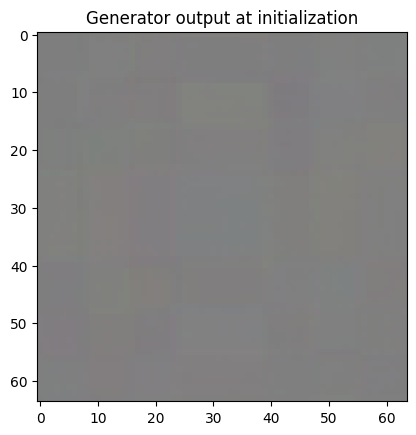

✓ TensorBoard launched (PID: 61847)
--- 🚀 Starting Pre-computation (One-time Setup) ---


/Users/lee_eason/CS/DL_comp/DL_comp3/.venv/lib/python3.10/site-packages/tensorboard/default.py:30: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Found 7370 unique images.
Extracting Image Features (This caches CLIP outputs to VRAM)...


Encoding Images:   0%|          | 0/58 [00:01<?, ?it/s]


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/Users/lee_eason/CS/DL_comp/DL_comp3/.venv/lib/python3.10/site-packages/tensorboard/compat/__init__.py", line 42, in tf
    from tensorboard.compat import notf  # noqa: F401
ImportError: cannot import name 'notf' from 'tensorboard.compat' (/Users/lee_eason/CS/DL_comp/DL_comp3/.venv/lib/python3.10/site-packages/tensorboard/compat/__init__.py)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/lee_eason/.local/share/uv/python/cpython-3.10.17-macos-aarch64-none/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/lee_eason/.local/share/uv/python/cpython-3.10.17-macos-aarch64-none/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/lee_eason/CS/DL_comp/DL_comp3/.venv/lib/python3.10/site-packages/tensorboard/main.py", line 48, in <module>
    run_main()
  File "/Users/lee_eas

In [36]:
# Pass the dictionaries directly
train(config, word2Id_dict, id2word_dict)


<h2 id="Visualiztion">Visualiztion<a class="anchor-link" href="#Visualiztion">¶</a></h2>
<p>During training, we can visualize the generated image to evaluate the quality of generator. The followings are some functions helping visualization.</p>




<p>We always use same random seed and same senteces during training, which is more convenient for us to evaluate the quality of generated image.</p>




<h2 id="Training">Training<a class="anchor-link" href="#Training">¶</a></h2>




<h2 id="Testing-Dataset">Testing Dataset<a class="anchor-link" href="#Testing-Dataset">¶</a></h2>
<p>If you change anything during preprocessing of training dataset, you must make sure same operations have be done in testing dataset.</p>



In [ ]:
def testing_data_generator(caption_text, index):
		"""
		Updated testing data generator using CLIP tokenization
		
		Args:
				caption_text: Raw text string
				index: Test sample ID
		
		Returns:
				input_ids, attention_mask, index
		"""
		def tokenize_caption_clip(text):
				"""Python function to tokenize text using CLIP tokenizer"""
				# Convert EagerTensor to bytes, then decode to string
				text = text.numpy().decode('utf-8')
				
				# Tokenize using CLIP
				encoded = tokenizer(
						text,
						padding='max_length',
						truncation=True,
						max_length=77,
						return_tensors='np'
				)
				
				return encoded['input_ids'][0], encoded['attention_mask'][0]
		
		# Use tf.py_function to call Python tokenizer
		input_ids, attention_mask = tf.py_function(
				func=tokenize_caption_clip,
				inp=[caption_text],
				Tout=[tf.int32, tf.int32]
		)
		
		# Set shapes explicitly
		input_ids.set_shape([77])
		attention_mask.set_shape([77])
		
		return input_ids, attention_mask, index

def testing_dataset_generator(batch_size, data_generator):
		"""
		Updated testing dataset generator - decodes IDs to raw text
		"""
		data = pd.read_pickle('./dataset/testData.pkl')
		captions_ids = data['Captions'].values
		caption_texts = []
		
		# Decode pre-tokenized IDs back to text
		for i in range(len(captions_ids)):
				chosen_caption_ids = captions_ids[i]
				
				# Decode IDs back to text using id2word_dict
				words = []
				for word_id in chosen_caption_ids:
						word = id2word_dict[str(word_id)]
						if word != '<PAD>':  # Skip padding tokens
								words.append(word)
				
				caption_text = ' '.join(words)
				caption_texts.append(caption_text)
		
		index = data['ID'].values
		index = np.asarray(index)
		
		# Create dataset from raw text
		dataset = tf.data.Dataset.from_tensor_slices((caption_texts, index))
		dataset = dataset.map(data_generator, num_parallel_calls=tf.data.AUTOTUNE)
		dataset = dataset.repeat().batch(batch_size)
		
		return dataset

In [ ]:
testing_dataset = testing_dataset_generator(BATCH_SIZE, testing_data_generator)


In [ ]:
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / BATCH_SIZE)



<h2 id="Inferece">Inferece<a class="anchor-link" href="#Inferece">¶</a></h2>



In [ ]:
# Create inference directory inside the run directory
inference_dir = os.path.join(config['RUN_DIR'], 'inference')
if not os.path.exists(inference_dir):
	os.makedirs(inference_dir)
print(f"Inference Directory: {inference_dir}")

In [ ]:
def inference(dataset, config):
	print("--- Starting Inference (Corrected for GALIP) ---")
	
	# 1. Re-initialize CLIP (Required for Tokenizer and Encoder)
	print("Loading CLIP components...")
	try:
		from transformers import TFCLIPModel, CLIPTokenizer
		clip_model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
		tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
		
		# Re-create the specific Encoder wrapper used in training
		text_encoder = CLIP_Text_Encoder(clip_model)
		print("✓ CLIP Model & Encoder loaded")
	except Exception as e:
		print(f"⚠ Error loading CLIP: {e}")
		return

	# 2. Load Generator
	print("Loading Generator...")
	# Initialize with same args as training
	generator = NetG(ngf=config['NGF'], nz=config['Z_DIM'], cond_dim=config['EMBED_DIM'], clip_model=clip_model)
	
	# Run a dummy forward pass to initialize variables before loading weights
	dummy_noise = tf.random.normal([1, config['Z_DIM']])
	dummy_text = tf.random.normal([1, config['EMBED_DIM']])
	_ = generator([dummy_noise, dummy_text], training=False)
	
	# Restore Checkpoint
	checkpoint_dir = os.path.join(config['RUN_DIR'], 'checkpoints')
	# Use expect_partial() because we are strictly loading the generator, 
	# ignoring optimizer states or discriminator if they exist in the ckpt
	checkpoint = tf.train.Checkpoint(generator=generator)
	latest_ckpt = tf.train.latest_checkpoint(checkpoint_dir)
	
	if latest_ckpt:
		print(f"Loading weights from: {latest_ckpt}")
		status = checkpoint.restore(latest_ckpt).expect_partial()
		status.assert_existing_objects_matched()
		print("✓ Generator weights loaded successfully")
	else:
		print("⚠ NO CHECKPOINT FOUND! Generating with random weights.")

	# 3. Inference Loop
	inference_dir = os.path.join(config['RUN_DIR'], 'inference')
	if not os.path.exists(inference_dir): os.makedirs(inference_dir)
		
	total_images = 0
	
	# Iterate over the testing dataset
	# Note: testing_dataset yields (caption_texts, ids)
	for step, (caption_texts, image_ids) in enumerate(tqdm(dataset, desc='Generating')):
		
		batch_size_curr = len(caption_texts)
		
		# --- A. Tokenize using CLIP (Not dictionary!) ---
		# Convert tensors to string list
		text_list = [t.numpy().decode('utf-8') for t in caption_texts]
		
		enc = tokenizer(
			text_list,
			padding='max_length',
			truncation=True,
			max_length=77, # CLIP default
			return_tensors='tf'
		)
		input_ids = enc['input_ids']
		attention_mask = enc['attention_mask']
		
		# --- B. Encode Text using CLIP (Not RNN!) ---
		sent_emb, _ = text_encoder(input_ids, attention_mask=attention_mask)
		
		# --- C. Generate ---
		noise = tf.random.normal([batch_size_curr, config['Z_DIM']])
		fake_imgs = generator([noise, sent_emb], training=False)
		
		# Post-process
		fake_imgs = (fake_imgs + 1.0) * 0.5
		fake_imgs = tf.clip_by_value(fake_imgs, 0.0, 1.0).numpy()
		
		# Save
		for i in range(batch_size_curr):
			try:
				# Handle ID decoding safely
				img_id_val = image_ids[i].numpy()
				if isinstance(img_id_val, bytes):
					img_id = img_id_val.decode('utf-8')
				else:
					img_id = str(img_id_val)
					
				save_path = os.path.join(inference_dir, f'inference_{img_id}.jpg')
				plt.imsave(save_path, fake_imgs[i])
				total_images += 1
			except Exception as e:
				print(f"Error saving image {i}: {e}")
				
	print(f"Inference Complete. Saved {total_images} images.")

In [ ]:
inference(testing_dataset, config)

In [ ]:
# Run evaluation script to generate score.csv
# Note: This must be run from the testing directory because inception_score.py uses relative paths
# Arguments: [inference_dir] [output_csv] [batch_size]
# Batch size must be 1, 2, 3, 7, 9, 21, or 39 to avoid remainder (819 test images)

# Save score.csv inside the run directory
print("running in ", inference_dir, "with", run_dir)
!cd testing && python inception_score.py ../{inference_dir}/ ../{run_dir}/score.csv 39

## Visualize Generated Images

Below we randomly sample 20 images from our generated test results to visually inspect the quality and diversity of the model's outputs.


<h1><center class="subtitle">Demo</center></h1>

<p>We demonstrate the capability of our model (TA80) to generate plausible images of flowers from detailed text descriptions.</p>



In [ ]:
# Visualize 20 random generated images with their captions
import glob

# Load test data
data = pd.read_pickle('./dataset/testData.pkl')
test_captions = data['Captions'].values
test_ids = data['ID'].values

# Get all generated images from the current inference directory
image_files = sorted(glob.glob(inference_dir + '/inference_*.jpg'))

if len(image_files) == 0:
		print(f'⚠ No images found in {inference_dir}')
		print('Please run the inference cell first!')
else:
		# Randomly sample 20 images
		np.random.seed(42)  # For reproducibility
		num_samples = min(20, len(image_files))
		sample_indices = np.random.choice(len(image_files), size=num_samples, replace=False)
		sample_files = [image_files[i] for i in sorted(sample_indices)]

		# Create 4x5 grid
		fig, axes = plt.subplots(4, 5, figsize=(20, 16))
		axes = axes.flatten()

		for idx, img_path in enumerate(sample_files):
				# Extract image ID from filename
				img_id = int(Path(img_path).stem.split('_')[1])
				
				# Find caption
				caption_idx = np.where(test_ids == img_id)[0][0]
				caption_ids = test_captions[caption_idx]
				
				# Decode caption
				caption_text = ''
				for word_id in caption_ids:
						word = id2word_dict[str(word_id)]
						if word != '<PAD>':
								caption_text += word + ' '
				
				# Load and display image
				img = plt.imread(img_path)
				axes[idx].imshow(img)
				axes[idx].set_title(f'ID: {img_id}\n{caption_text[:60]}...', fontsize=8)
				axes[idx].axis('off')

		# Hide unused subplots if less than 20 images
		for idx in range(num_samples, 20):
				axes[idx].axis('off')

		plt.tight_layout()
		plt.suptitle(f'Random Sample of {num_samples} Generated Images', fontsize=16, y=1.002)
		plt.show()

		print(f'\nTotal generated images: {len(image_files)}')
		print(f'Images directory: {inference_dir}')